## Многослойный персептрон

Как мы видели, однослойный персептрон может классифицировать только линейно разделимые множества. Для того, чтобы иметь возможность автоматически использовать сложные поверхности, необходимо несколько слоёв!

Кроме того, исходные персептрон Розенблатта корректировал веса только на основании неправильно классифицированных примеров. Более правильный подход был бы использовать **функцию ошибки**, как это делается в моделях машинного обучения.

> На самом деле, как мы вскоре увидим, однослойный персептрон с функцией ошибки представляет собой полный аналог линейной/логистической регрессии, обучаемой методом градиентного спуска. Мощь нейросетевого подхода начинает проявляться при увеличении количества слоёв.

In [5]:
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
np.random.seed(0)
import random

Начнём с рассмотрения традиционной двухмерной задачи классификации на 2 класса:


In [6]:
n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Разбиваем на обучающую и тестовые выборки
train_x, test_x = np.split(X, [n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])

In [7]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    plt.show()

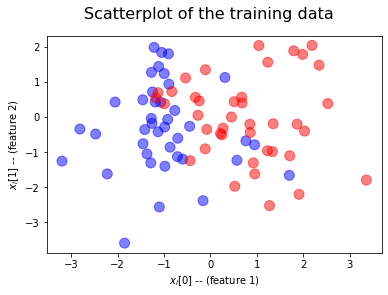

In [8]:
plot_dataset('Scatterplot of the training data', train_x, train_labels)

Вот как выглядят наши данные:

In [9]:
print(train_x[:5])
print(train_labels[:5])

[[ 1.3382818  -0.98613256]
 [ 0.5128146   0.43299454]
 [-0.4473693  -0.2680512 ]
 [-0.9865851  -0.28692   ]
 [-1.0693829   0.41718036]]
[1 1 0 0 0]


### Функции потерь

Чтобы правильно оценить ошибку нейросети, используют **функции потерь**, или функцию ошибки (*loss function*).

#### Функции потерь для регрессии

* Абсолютная ошибка: $\mathcal{L}_{abs}(\theta) = \sum_{i=1}^n |y_i - f_{\theta}(x_i)|$
* Среднеквадратичная ошибка: $\mathcal{L}_{sq}(\theta) = \sum_{i=1}^n (y_i - f_{\theta}(x_i))^2$


In [10]:
def plot_loss_functions(suptitle, functions, ylabels, xlabel):
    fig, ax = plt.subplots(1,len(functions), figsize=(9, 3))
    plt.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle)
    for i, fun in enumerate(functions):
        ax[i].set_xlabel(xlabel)
        if len(ylabels) > i:
            ax[i].set_ylabel(ylabels[i])
        ax[i].plot(x, fun)
    plt.show()

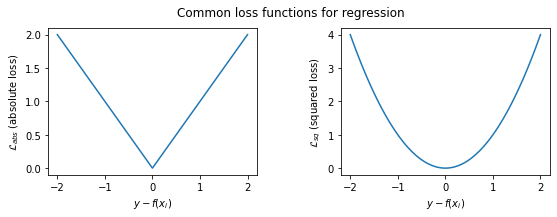

In [11]:
x = np.linspace(-2, 2, 101)
plot_loss_functions(
    suptitle = 'Common loss functions for regression',
    functions = [np.abs(x), np.power(x, 2)],
    ylabels   = ['$\mathcal{L}_{abs}}$ (absolute loss)',
                 '$\mathcal{L}_{sq}$ (squared loss)'],
    xlabel    = '$y - f(x_i)$')

#### Функции потерь для классификации

**0-1 loss**

Предполагается решающая функция вида $\hat{y} = \mathrm{sign}(f_{\theta}(x))$:

$\mathcal{L}_{0-1}(\theta) = \sum_{i=1}^n l_i \quad  l_i = \begin{cases}
         0 & y_i f_{\theta}(x) > 0 \\
         1 & в\ противном\ случае
       \end{cases} \\
$

**логистическая функция ошибки**

$\mathcal{L}_{log}(\theta) = \sum_{i=1}^n \frac{1}{\log(2)} \log(1 + e^{-y_i f_{\theta}(x)})$

In [12]:
# define and vectorize zero-one loss
def zero_one(d):
    if d < 0:
        return 1
    return 0

def logistic_loss(fx):
    # assumes y == 1
    y = 1
    return 1 / np.log(2) * np.log(1 + np.exp(-y * fx))

zero_one_v = np.vectorize(zero_one)

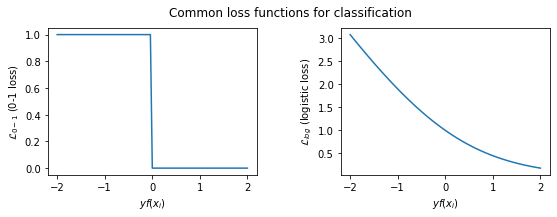

In [13]:
plot_loss_functions(suptitle = 'Common loss functions for classification',
                   functions = [zero_one_v(x), logistic_loss(x)],
                   ylabels    = ['$\mathcal{L}_{0-1}}$ (0-1 loss)',
                                 '$\mathcal{L}_{log}$ (logistic loss)'],
                   xlabel     = '$y f(x_i)$')


### Строим нейросеть

Рассмотрим решение нашей задачи при помощи простейшей однослойной нейросети такого вида:
<img src="images/NeuroArch.png" width="50%"/>

Будем сразу рассматривать задачу как задачу мультиклассовой классификации - поэтому сделаем у сети два выхода и, соответственно, два решающих нейрона. Возможно, конечно, решать задачу бинарной классификации с помощью одного нейрона - в этом случае у него на выходе будет формироваться вероятность того, что входные значения соответствуют классу 1. В случае мультиклассовой классификации на каждом из выходов будет вероятность появления соответствующего класса.

Модель будет описываться как
$$
f_\theta(x) = W\times x + b
$$
где параметры $$\theta = <W,b>$$

In [14]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        
    def forward(self, x):
        return np.dot(x, self.W.T) + self.b
    
net = Linear(2,2)
net.forward(train_x[0:5])

array([[ 1.77202116, -0.25384488],
       [ 0.28370828, -0.39610552],
       [-0.30097433,  0.30513182],
       [-0.8120485 ,  0.56079421],
       [-1.23519653,  0.3394973 ]])

### Переходим к вероятностям

На выходе такой линейной модели могут быть произвольные значения. Чтобы сделать из них вероятности, расширяем нейросетевую модель с помощью функции **softmax**: $$\sigma(\mathbf{z}_c) = \frac{e^{z_c}}{\sum_{j \in J} e^{z_j}}$$ для  $c \in 1 .. |C|$

> Для бинарной классификации, как и для логистической регрессии, используется рассмотренная нами функция сигмоид.

<img src="images/NeuroArch-softmax.PNG" width="50%">

Можем рассматривать $\sigma(\mathbf{z})$ как распределение вероятности на классах $C$: $q = \sigma(\mathbf{z}_c) = \hat{p}(c | x)$

In [15]:
class Softmax:
    def forward(self,z):
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z

softmax = Softmax()
softmax.forward(net.forward(train_x[0:10]))

array([[0.88348621, 0.11651379],
       [0.66369714, 0.33630286],
       [0.35294795, 0.64705205],
       [0.20216095, 0.79783905],
       [0.17154828, 0.82845172],
       [0.24279153, 0.75720847],
       [0.18915732, 0.81084268],
       [0.17282951, 0.82717049],
       [0.13897531, 0.86102469],
       [0.72746882, 0.27253118]])

### Архитектура сети для MNIST

![Архитектура нейросети](images/Cross-Entropy-Loss.PNG)


### Cross-Entropy Loss

Для бинарной классификации мы ранее рассматривали **логистическую функцию ошибки**. В случае мультиклассовой классификации такая ошибка называется **Cross-Entropy Loss**, и она повсеместно применяется в глубоком обучении. 

Основная идея: мы трактуем выход модели как распределение вероятностей появления того или иного класса и минимизируем вероятность неправильной классификации. Предположим, на вход сети подали пример $x$, для которого ожидаемый номер класса - $i$, тогда ошибка будет вычисляться как $-\log p_i$. Если мы предсказали правильный класс с вероятностью 1, то ошибка равна 0, и ошибка тем больше, чем ближе предсказанная вероятность правильного класса к 0.

> Название cross-entropy loss происходит из более фундаментального понятия энтропии, которая позволяет вычислить ошибку между двумя произвольными разпределениями вероятности $p$ и $q$. В нашем случае, одно из распределений вероятности $p$ представляет собой выколотую точку ($p(i)=1$, $p(k)=0$ для $k\ne i$), что упрощает формулу до приведённой выше.

$\begin{align} H(p, q) = & ~\color{red}{H(p)} + \color{blue}{D_{KL}(p||q)} \\
    = & ~\color{red}{-\sum_{c \in C} p(c) \log p(c)} + \color{blue}{\sum_{c \in C} p(c) \log \frac{p(c)}{q(c)}} \\
    = & ~-\sum_{c \in C} p(c) \log q(c)\\
    = & -\log q(i)
\end{align}$


In [16]:
def plot_cross_ent():
    p = np.linspace(0.01, 0.99, 101) # estimated probability p(y|x)
    cross_ent_v = np.vectorize(cross_ent)
    f3, ax = plt.subplots(1,1, figsize=(8, 3))
    l1, = plt.plot(p, cross_ent_v(p, 1), 'r--')
    l2, = plt.plot(p, cross_ent_v(p, 0), 'r-')
    plt.legend([l1, l2], ['$y = 1$', '$y = 0$'], loc = 'upper center', ncol = 2)
    plt.xlabel('$\hat{p}(y|x)$', size=18)
    plt.ylabel('$\mathcal{L}_{CE}$', size=18)
    plt.show()

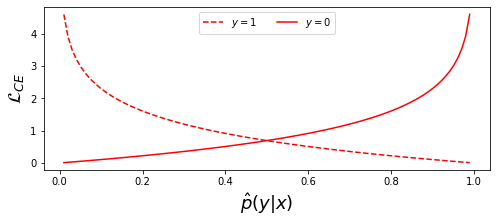

In [17]:
def cross_ent(prediction, ground_truth):
    t = 1 if ground_truth > 0.5 else 0
    return -t * np.log(prediction) - (1 - t) * np.log(1 - prediction)
plot_cross_ent()

In [18]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()

cross_ent_loss = CrossEntropyLoss()
p = softmax.forward(net.forward(train_x[0:10]))
cross_ent_loss.forward(p,train_labels[0:10])

1.429664938969559

### Вычислительный граф

Мы видим, что процесс вычисления выхода нейросети сводится к последовательному применению слоёв с помощью функции forward. Это удобно представлять себе как граф вычислений:

<img src="images/ComputeGraph.PNG" width="600px"/>

In [19]:
z = net.forward(train_x[0:10])
p = softmax.forward(z)
loss = cross_ent_loss.forward(p,train_labels[0:10])
print(loss)

1.429664938969559


### Обучение сети - задача минимизации

Описав нейронную сеть как модель $f_\theta$ и функцию ошибки $\mathcal{L}(Y,f_\theta(X))$, можем рассмотреть $\mathcal{L}$ как функцию $\theta$ на всем множестве обучающей выборки $\mathcal{L}(\theta) = \mathcal{L}(Y,f_\theta(X))$

В этом случае задача обучения сети будет формулироваться как задача минимизации $\mathcal{L}$ по $\theta$:
$$
\theta = \mathrm{argmin}_{\theta} \mathcal{L}(Y,f_\theta(X))
$$

Минимизацию можно осуществлять разными методами, например, градиентным спуском (stochastic gradient descent, SGD):

  * Для обучения сети необходимо предъявлять ей примеры, считать ошибку и подстраивать коэффициенты
  * В соответствии с принципом градиентного спуска, необходимо расчитывать изменение коэффициентов в соответствии с градиентом функции $\nabla f_\theta$
  * Итерация обучения выглядит так:
 $$\begin{align}
 W^{i+1}&=W^i-\eta\frac{\partial\mathcal{L}}{\partial W}\cr
 b^{i+1}&=b^i-\eta\frac{\partial\mathcal{L}}{\partial b}
 \end{align}
 $$

## Обратное распространение ошибки

<img src="images/ComputeGraph.PNG" width="300px" align="left"/>

$$
\begin{align}
\frac{\partial\mathcal{L}}{\partial W} =& \frac{\mathcal{\partial L}}{\partial p}\frac{\partial p}{\partial z}\frac{\partial z}{\partial W}\cr
\frac{\partial\mathcal{L}}{\partial b} =& \frac{\mathcal{\partial L}}{\partial p}\frac{\partial p}{\partial z}\frac{\partial z}{\partial b}
\end{align}
$$

<img src="images/ComputeGraphGrad.PNG" width="400px" align="right"/>

   * Не повторяем одинаковые вычисления
   * Вычисляем ошибку на каждом узле начиная с конца
   * Обратное распространение ошибки
   * Все вычисления фреймворк берёт на себя

### Реализация обратного распространения

* К каждому узлу добавляем функцию `backward`, которая вычисляет производную и значение ошибки
* После вычисления производных, реализуем обновление весов в соответствии с формулой выше

Например, для линейного узла $z = x\times W+b$:
$$\begin{align}
\frac{\partial z}{\partial W} &= x \\
\frac{\partial z}{\partial b} &= 1 \\
\end{align}$$

Соответственно, если на вход пришла ошибка $\Delta z$, то изменения весов вычисляются так:
$$\begin{align}
\Delta x &= \Delta z \times W \\
\Delta W &= \frac{\partial z}{\partial W} \Delta z = \Delta z \times x \\
\Delta b &= \frac{\partial z}{\partial b} \Delta z = \Delta z \\
\end{align}$$

**ВАЖНО:** Вычисления производятся не для одного элемента обучающей выборки, а сразу для целой последовательности, называемой **minibatch**. Необходимые значения градиентов $\Delta W$ и $\Delta b$ вычисляются по всей выборке, а вектора имеют соответствующую размерность: $x\in\mathbb{R}^{\mathrm{minibatch}\, \times\, \mathrm{nfeatures}}$, $x\in\mathbb{R}^{\mathrm{minibatch}\, \times\, \mathrm{nclass}}$ 

In [20]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

Аналогичный образом функции обратного распространения `backward` добавляются к другим составляющим вычислительного графа:

In [21]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

Теперь напишем цикл обучения модели на нашем датасете. Будем рассматривать один проход по модели - т.н. **эпоху**

In [22]:
lin = Linear(2,2)
softmax = Softmax()
cross_ent_loss = CrossEntropyLoss()

pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Initial accuracy: ",acc)

batch_size=4
for i in range(0,len(train_x),batch_size):
    xb = train_x[i:i+batch_size]
    yb = train_labels[i:i+batch_size]
    
    # forward pass
    z = lin.forward(xb)
    p = softmax.forward(z)
    loss = cross_ent_loss.forward(p,yb)
    
    # backward pass
    dp = cross_ent_loss.backward(loss)
    dz = softmax.backward(dp)
    dx = lin.backward(dz)
    lin.update(0.1)
    
pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Final accuracy: ",acc)
    

Initial accuracy:  0.725
Final accuracy:  0.825


Для удобства опишем класс, который позволяет объединять узлы вычислительного графа в единую сеть, и применять функции `forward` и `backward` сразу ко всей сети последовательно:

In [23]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

Ещё раз пробуем создать и обучить нашу нейросеть:

In [24]:
net = Net()
net.add(Linear(2,2))
net.add(Softmax())
loss = CrossEntropyLoss()

def get_loss_acc(x,y,loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))

def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    for i in range(0,len(train_x),batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)
 
train_epoch(net,train_x,train_labels)
        
print("Final loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
print("Test loss={}, accuracy={}: ".format(*get_loss_acc(test_x,test_labels)))

Initial loss=0.6212072429381601, accuracy=0.6875: 
Final loss=0.44369925927417986, accuracy=0.8: 
Test loss=0.4767711377257787, accuracy=0.85: 


In [25]:
def train_and_plot(n_epoch, net, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    fig, ax = plt.subplots(2, 1)
    ax[0].set_xlim(0, n_epoch + 1)
    ax[0].set_ylim(0,1)

    train_acc = np.empty((n_epoch, 3))
    train_acc[:] = np.NAN
    valid_acc = np.empty((n_epoch, 3))
    valid_acc[:] = np.NAN

    for epoch in range(1, n_epoch + 1):

        train_epoch(net,train_x,train_labels,loss,batch_size,lr)
        tloss, taccuracy = get_loss_acc(train_x,train_labels,loss)
        train_acc[epoch-1, :] = [epoch, tloss, taccuracy]
        vloss, vaccuracy = get_loss_acc(test_x,test_labels,loss)
        valid_acc[epoch-1, :] = [epoch, vloss, vaccuracy]
        
        ax[0].set_ylim(0, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)

        plot_training_progress(train_acc[:, 0], (train_acc[:, 2],
                                                 valid_acc[:, 2]), fig, ax[0])
        plot_decision_boundary(net, fig, ax[1])
        fig.canvas.draw()
        fig.canvas.flush_events()

    return train_acc, valid_acc

In [26]:
import matplotlib.cm as cm

def plot_decision_boundary(net, fig, ax):
    draw_colorbar = True
    # remove previous plot
    while ax.collections:
        ax.collections.pop()
        draw_colorbar = False

    # generate countour grid
    x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
    y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel().astype('float32'), yy.ravel().astype('float32')]
    n_classes = max(train_labels)+1
    while train_x.shape[1] > grid_points.shape[1]:
        # pad dimensions (plot only the first two)
        grid_points = np.c_[grid_points,
                            np.empty(len(xx.ravel())).astype('float32')]
        grid_points[:, -1].fill(train_x[:, grid_points.shape[1]-1].mean())

    # evaluate predictions
    prediction = np.array(net.forward(grid_points))
    # for two classes: prediction difference
    if (n_classes == 2):
        Z = np.array([0.5+(p[0]-p[1])/2.0 for p in prediction]).reshape(xx.shape)
    else:
        Z = np.array([p.argsort()[-1]/float(n_classes-1) for p in prediction]).reshape(xx.shape)
    
    # draw contour
    levels = np.linspace(0, 1, 40)
    cs = ax.contourf(xx, yy, Z, alpha=0.4, levels = levels)
    if draw_colorbar:
        fig.colorbar(cs, ax=ax, ticks = [0, 0.5, 1])
    c_map = [cm.jet(x) for x in np.linspace(0.0, 1.0, n_classes) ]
    colors = [c_map[l] for l in train_labels]
    ax.scatter(train_x[:, 0], train_x[:, 1], marker='o', c=colors, s=60, alpha = 0.5)

In [27]:
def plot_training_progress(x, y_data, fig, ax):
    styles = ['k--', 'g-']
    # remove previous plot
    while ax.lines:
        ax.lines.pop()
    # draw updated lines
    for i in range(len(y_data)):
        ax.plot(x, y_data[i], styles[i])
    ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],
              loc='upper center', ncol = 2)

In [28]:
%matplotlib nbagg 

net = Net()
net.add(Linear(2,2))
net.add(Softmax())

res = train_and_plot(30,net,lr=0.005)

<IPython.core.display.Javascript object>

## Многослойная модель

С построенной нами архитектурой на основе вычислительного графа легко описывать многослойные персептроны! При этом важно на забывать про **передаточную функцию** между слоями, поскольку без передаточной функции последовательное применение линейных слоёв эквивалентно применению одного линейного слоя. В качестве передаточной функции между слоями можно использовать `tanh`, или сигмоид

> В более глубоких сетях также очень важна первоначальная инициализация весов случайными значениями. Если про это забыть, то можем получить модель, которая не будет сходиться.

In [29]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

In [30]:
net = Net()
net.add(Linear(2,5))
net.add(Tanh())
net.add(Linear(5,2))
net.add(Softmax())
loss = CrossEntropyLoss()

In [31]:
res = train_and_plot(30,net,lr=0.01)

<IPython.core.display.Javascript object>

## Переобучение

По мере того, как нейросетевая модель становится более выразительной, вырастает опасность т.н. **переобучения**. Это ситуация, когда модель очень точно приближает элементы обучающей выборки, но при этом перестает хорошо **обобщаться** на другие тестовые примеры.

<img src="images/overfit.png" width="80%"/>

Простая линейная модель:
* высокий training loss - "недообучение", выразительности модели не хватает, чтобы разделить данные
* valiadation loss и training loss примерно совпадают - модель хорошо обобщается

Сложная многослойная модель:
* низкий training loss - почти идеально приближает обучающую выборку (но может переобучиться)
* validation loss >> training loss и может возрастать - плохо обобщает данные

Способы борьбы с переобучением:
* Увеличить количество обучающих примеров
* Уменьшить количество параметров модели

## Выводы

* Многослойные персептроны хорошо разделяют линейно неразделимые множества
* Мы построили простой нейросетевой фреймворк, позволяющий легко комбинировать слои. Основные его возможности: вычисления (`forward`) и дифференциирование всех функций перехода (`backward`)
* При использовании большого числа слоёв (и параметров в целом) возможно переобучение:
    * Простые модели с небольшим числом параметров ("low capacity") менее склонные к переобучению
    * Более сложные модели (high capacity) могут переобучиться (надо следить за validation error)
    * Для более сложных моделей необходимо иметь больше данных
    * "bias-variance trade-off" - необходимо достичь компромисса между недообучением и переобучением (обучением на распознавание нерелевантного шума во входных данных)
    * Лучше начинать с простых моделей и переходить на более сложные